## Problem Definition

In [243]:
import scipy
import numpy as np
import gym
from gym import spaces
import random

def optimal_lqr_control(A, B, Q, R):

    '''
    Solve the continuous-time LQR problem given A, B, Q, R.

    Parameters
    ----------
    A : numpy.ndarray
        The state matrix.
    B : numpy.ndarray
        The control matrix.
    Q : numpy.ndarray
        The state cost matrix.
    R : numpy.ndarray
        The control cost matrix.

    Returns
    -------
    K : numpy.ndarray
        The optimal LQR gain.
    '''
    # Solve the Riccati equation
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    # Compute the LQR gain
    K = np.linalg.inv(R) @ B.T @ P

    return K

class CircleRotationEnv(gym.Env):

    def __init__(self,
                 s_inits: np.array,
                 k_x=0,
                 k_y=0,
                 k_p=0,
                 q_x=1,
                 q_y=1,
                 q_r=0.2,
                 theta=0,
                 sigma_noise=0.0):
        
        self.k_x = k_x
        self.k_y = k_y
        self.k_p = k_p
        self.q_x = q_x
        self.q_y = q_y
        self.q_r = q_r
        self.theta = theta
        self.state_dim = 2
        self.action_dim = 2
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)

        # Define system dynamics
        self.A = np.array([[-(k_x + k_p), 0.0],
                           [0.0, -(k_y + k_p)]])
        self.B_init = np.eye(2)
        self.B = self.B_init
    
        self.Q = np.array([[self.q_x, 0.0],
                      [0.0, self.q_y]])
        self.R = np.eye(2) * self.q_r

        self.s_inits = s_inits
        self.s_0 = random.choice(self.s_inits)
        self.s = self.s_0

        self.episode_length = 100
        self.step_count = 0
        self.step_width = 1
        self.goal_state = np.array([0,0], dtype=np.float32) #only used to check whether agent reached goal state.


    def reset(self):

        '''
        Reset the system to its initial state. Does not reset the rotation matrix.
        '''

        self.step_count = 0
        self.s = random.choice(self.s_inits).copy()
        return self.s
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''


        self.s+= self.step_width*(self.A @ self.s + self.B @ u)
        self.s += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        reward = -(self.s @ self.Q @ self.s + u @ self.R @ u)
        self.step_count += 1

        if self.step_count == self.episode_length or np.allclose(self.s, self.goal_state, atol=0.1):
            done = True
            self.step_count = 0
        else:
            done = False

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]


    # def rotate_B(self, theta):
    def rotate_S(self, theta):

        '''
        Rotates the matrix B by angle theta. Theta is in degrees, rather than radians.
        '''
        self.B = self.B_init

        theta = np.radians(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                    [np.sin(theta), np.cos(theta)]])
        # self.B = self.B @ rotation_matrix
        self.s_0 = rotation_matrix @ self.s_0


    def generate_evenly_spread_rotation_angles(self, N_tasks):

        '''
        Evenly spreads rotation angles between 0 and 360 degrees.

        Args:
            N_tasks (int): Number of tasks to generate.

        Returns:
            theta_values (np.array): Array of rotation angles in degrees.
        '''

        _min_angle = 0
        _max_angle = 360-360/N_tasks

        return np.linspace(_min_angle, _max_angle, N_tasks)


In [247]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Make the environment
s_inits = [np.array([1,0], dtype=np.float32)]
env = CircleRotationEnv(s_inits=s_inits)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=os.cpu_count())

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1)

# Train the model
model.learn(total_timesteps=100_000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | -47.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 830      |
|    time_elapsed    | 0        |
|    total_timesteps | 407      |
| train/             |          |
|    actor_loss      | -0.262   |
|    critic_loss     | 0.893    |
|    ent_coef        | 0.992    |
|    ent_coef_loss   | -0.0262  |
|    learning_rate   | 0.0003   |
|    n_updates       | 27       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.2     |
|    ep_rew_mean     | -71.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 725      |
|    time_elapsed    | 1        |
|    total_timesteps | 781      |
| train/             |          |
|    actor_loss      | -0.796   |
|    critic_loss     | 0.624   

## Visualize Policy

In [237]:
def generate_circle_points(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N = 8
circle_points = generate_circle_points(N)
print(circle_points)

[[ 1.00000000e+00  0.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01]
 [ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]]


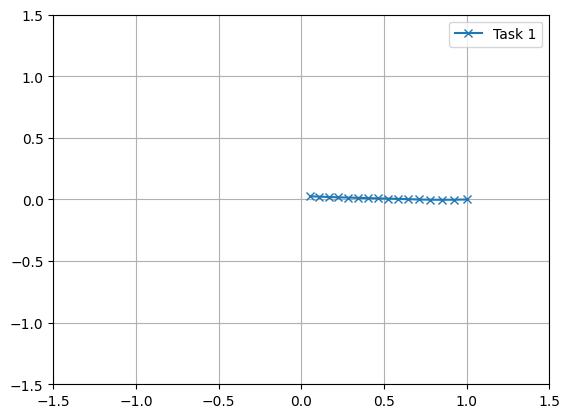

In [250]:
import matplotlib.pyplot as plt


n_steps = 100
obs = env.reset()
trajectory = []
rewards = []
actions = []
trajectory.append(obs.copy())

for _ in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    actions.append(action)
    trajectory.append(obs.copy())
    rewards.append(reward)

    if done:
        break  # end the rollout

trajectory = np.array(trajectory)
rewards = np.array(rewards)

plt.plot(trajectory[:,0], trajectory[:,1], label="Task 1", marker="x")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid()

## Meta-Setup

In [142]:
N_TASKS=4
TRAJ_LENGTH=25
SIGMA_NOISE = 0.0
_task_generator = CircleRotation()
_task_ms = _task_generator.generate_evenly_spread_rotation_angles(N_TASKS)

base_task = CircleRotation(sigma_noise=SIGMA_NOISE)
base_task.rotate_S(theta=_task_ms[0])

task_1 = CircleRotation(sigma_noise=SIGMA_NOISE)
task_1.rotate_S(theta=_task_ms[1])
task_2 = CircleRotation(sigma_noise=SIGMA_NOISE)
task_2.rotate_S(theta=_task_ms[2])
task_3 = CircleRotation(sigma_noise=SIGMA_NOISE)
task_3.rotate_S(theta=_task_ms[3])

del _task_generator

assert (base_task.A==task_1.A).all()
assert (base_task.Q==task_1.Q).all()
assert (base_task.R==task_1.R).all()

K_star_base = optimal_lqr_control(A=base_task.A, B=base_task.B, Q=base_task.Q, R=base_task.R)
K_star_task_1 = optimal_lqr_control(A=task_1.A, B=task_1.B, Q=task_1.Q, R=task_1.R)
K_star_task_2 = optimal_lqr_control(A=task_2.A, B=task_2.B, Q=task_2.Q, R=task_2.R)
K_star_task_3 = optimal_lqr_control(A=task_3.A, B=task_3.B, Q=task_3.Q, R=task_3.R)

policy_star_base = lambda s: -K_star_base @ s
policy_star_task_1 = lambda s: -K_star_task_1 @ s
policy_star_task_2 = lambda s: -K_star_task_2 @ s
policy_star_task_3 = lambda s: -K_star_task_3 @ s


trajectory_base, controls_base, costs_base = base_task.sample_traj(policy=policy_star_base, T=TRAJ_LENGTH)
trajectory_task_1, controls_task_1, costs_task_1 = task_1.sample_traj(policy=policy_star_task_1, T=TRAJ_LENGTH)
trajectory_task_2, controls_task_2, costs_task_2 = task_2.sample_traj(policy=policy_star_task_2, T=TRAJ_LENGTH)
trajectory_task_3, controls_task_3, costs_task_3 = task_3.sample_traj(policy=policy_star_task_3, T=TRAJ_LENGTH)


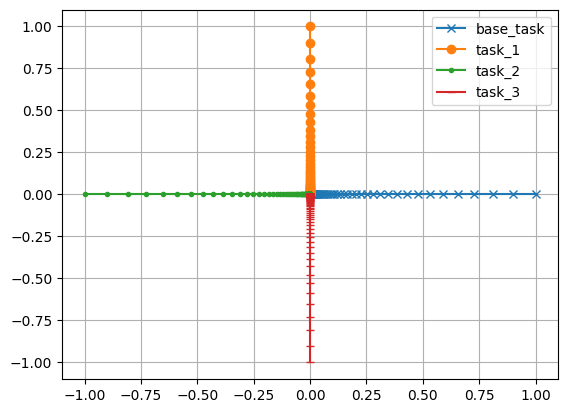

In [143]:
import matplotlib.pyplot as plt

plt.plot(trajectory_base[:,0], trajectory_base[:,1,], label="base_task", marker="x")
plt.plot(trajectory_task_1[:,0], trajectory_task_1[:,1,], label="task_1", marker="o")
plt.plot(trajectory_task_2[:,0], trajectory_task_2[:,1,], label="task_2", marker=".")
plt.plot(trajectory_task_3[:,0], trajectory_task_3[:,1,], label="task_3", marker="_")
plt.grid()
plt.legend()

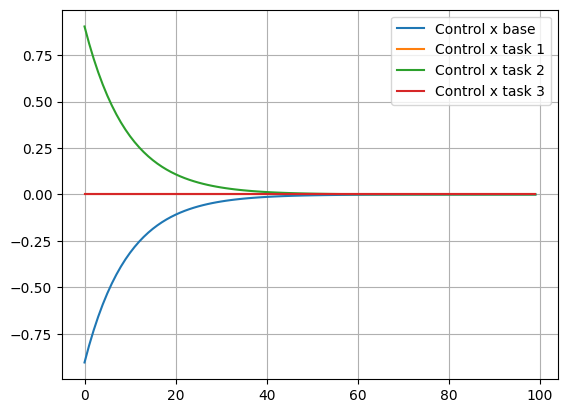

In [144]:
plt.plot(controls_base[:,0], label="Control x base")
plt.plot(controls_task_1[:,0], label="Control x task 1")
plt.plot(controls_task_2[:,0], label="Control x task 2")
plt.plot(controls_task_3[:,0], label="Control x task 3")
plt.grid()
plt.legend()

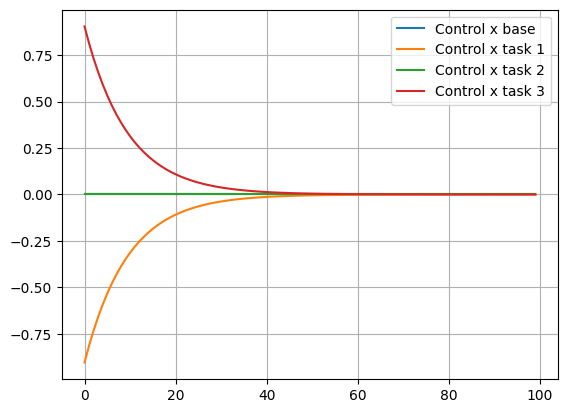

In [145]:
plt.plot(controls_base[:,1], label="Control x base")
plt.plot(controls_task_1[:,1], label="Control x task 1")
plt.plot(controls_task_2[:,1], label="Control x task 2")
plt.plot(controls_task_3[:,1], label="Control x task 3")
plt.grid()
plt.legend()

## Train SAC Policy

## Roll-Out New Task

In [146]:
traj_prime, controls_prime, costs_prime = task_1.sample_traj(policy=policy_star_base, T=TRAJ_LENGTH)

theta = np.radians(_task_ms[1])
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

s_0_prime = traj_prime[0,:]
s_1_prime = traj_prime[1,:]

a_0_prime = controls_prime[0,:]

In [130]:
s_0_prime

array([-1., -1.])

In [131]:
s_1_prime

array([-1.08049881, -0.89950126])

In [127]:
a_0_prime

array([0.90498756, 0.90498756])

In [128]:
controls_base[0,:]

array([0.90498756, 0.90498756])

In [133]:
policy_star_base(rotation_matrix @ s_0_prime)

array([-0.90498756,  0.90498756])

In [134]:
policy_star_base(s_0_prime)

array([0.90498756, 0.90498756])

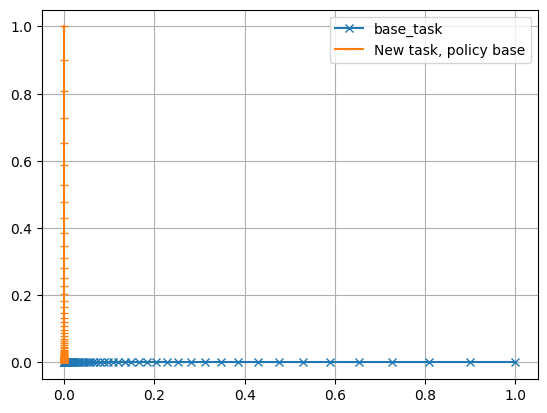

In [147]:
plt.plot(trajectory_base[:,0], trajectory_base[:,1,], label="base_task", marker="x")
plt.plot(traj_prime[:,0], traj_prime[:,1,], label="New task, policy base", marker="_")
plt.grid()
plt.legend()